In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from datasets.ner_dataset import get_ner_dataset, NerDataset

In [4]:
def plot_class_distribution(data: NerDataset) -> pd.DataFrame:
    token_list = []
    for i in range(len(data)):
        token_list.extend(list(map(lambda x: (x[0].item(), data.index2label[x[1].item()]), 
                                   zip(*data[i][1:]))))
    print(f"The number of all tokens: {len(token_list)}")
    df = pd.DataFrame(token_list, columns=['token','label'])
    print(df['label'].value_counts(normalize = False))
    distr = df['label'].loc[df['label'] != 'O'].value_counts(normalize = True)
    fig = plt.figure(figsize=(15, 5))
    with sns.plotting_context("talk", font_scale=0.5), sns.axes_style('whitegrid'), sns.mpl_palette("GnBu_d", n_colors=len(distr)):
        sns.barplot(x=distr.index, y=distr.values).set_title('Тренировочная выборка')
    return df

In [5]:
def plot_len_distribution(data: NerDataset):
    len_list = [len(data[i][1]) for i in range(len(data))]
    print(f"The number of records: {len(len_list)}")
    df = pd.DataFrame({'length': len_list})
    print(f"The mean length: {df['length'].mean()}")
    fig = plt.figure(figsize=(16, 8))
    with sns.plotting_context("talk", font_scale=0.7), sns.axes_style('whitegrid'), sns.mpl_palette("GnBu_d"):
        sns.histplot(df['length'], kde=False, bins=50).set_title("Распределение количества токенов в записях")

### Этап 5: Дополнительное исследование данных

Анализ данных будет проходить на онснове токенизатора основной модели "bert-large-uncased".

#### i2b2 2014

In [6]:
data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)
train_dataset = get_ner_dataset(data_type=data_config["train_data_type"],
                                path_to_folder=data_config["train_data_path"],
                                is_uncased=True,
                                pretrained_tokenizer="bert-large-uncased",
                                max_length=data_config["max_token_number"],
                                overlap=data_config["overlap"],
                                eq_max_padding=False, 
                                device="cpu")
val_dataset = get_ner_dataset(data_type=data_config["val_data_type"],
                              path_to_folder=data_config["validate_data_path"],
                              is_uncased=data_config["is_uncased"],
                              pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                              max_length=data_config["max_token_number"],
                              overlap=data_config["overlap"],
                              eq_max_padding=False, 
                              device="cpu")

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


The number of all tokens: 1438845
O             1319481
DATE            50531
[PAD]           29678
NAME            18570
LOCATION         9858
ID               6224
AGE              2020
CONTACT          1653
PROFESSION        830
Name: label, dtype: int64


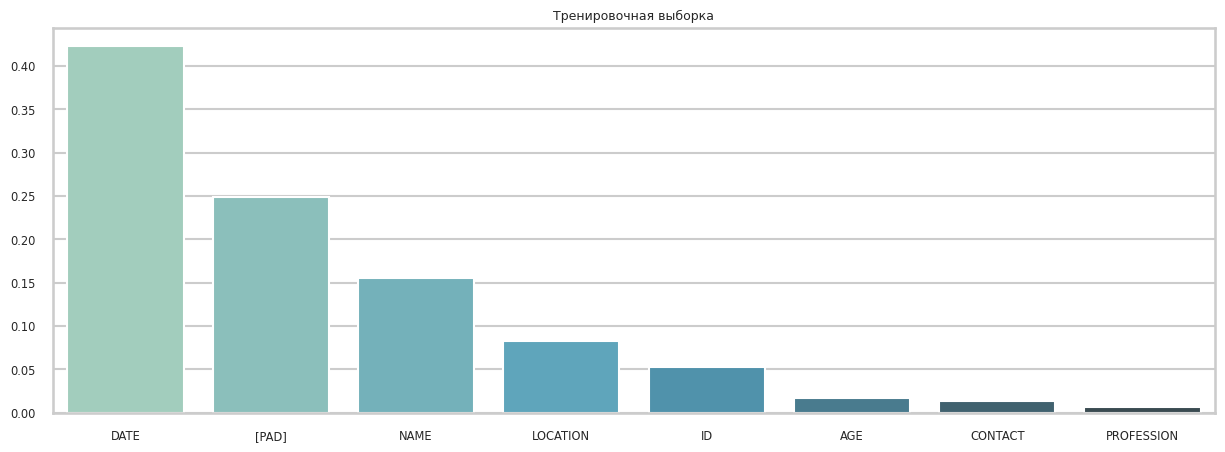

In [7]:
train_df = plot_class_distribution(train_dataset)

The number of all tokens: 925554
O             847998
DATE           32754
[PAD]          19114
NAME           11741
LOCATION        6211
ID              4510
AGE             1300
CONTACT         1270
PROFESSION       656
Name: label, dtype: int64


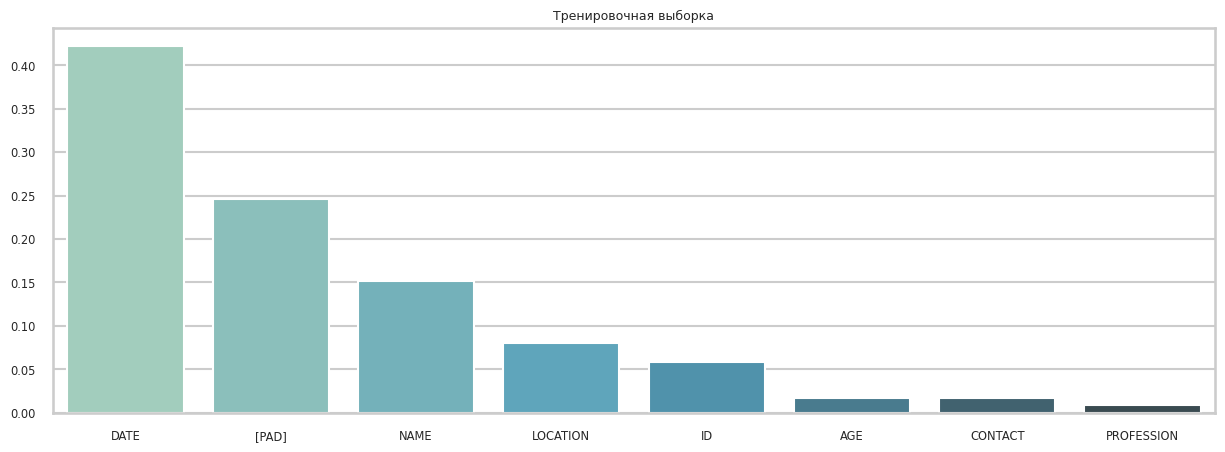

In [8]:
val_df = plot_class_distribution(val_dataset)

Заметим, что около $90\%$  токенов являются 'OTHER' и распозоваемые сущности занимают менее 10% всего текста, т.к одна четверть токенов являются техническими. Распознаваемые классы распределены неравномерно. Среди них самым популярным является класс 'DATE', оставшиеся классы встречаются в два раза реже. А самым редким классом, который определён только у 830 токенов, является 'PROFESSION', что приводит к относительно низкому качеству его распозавания всеми моделями.  
Распределение классов в тренировочной и валидационной выборке совпадает. При этом обучающая выборка лишь в полтора раза больше тестовой.

In [9]:
train_dataset = get_ner_dataset(data_type=data_config["train_data_type"],
                                path_to_folder=data_config["train_data_path"],
                                is_uncased=True,
                                pretrained_tokenizer="bert-large-uncased",
                                max_length=None,
                                overlap=data_config["overlap"],
                                eq_max_padding=False, 
                                device="cpu")
val_dataset = get_ner_dataset(data_type=data_config["val_data_type"],
                              path_to_folder=data_config["validate_data_path"],
                              is_uncased=data_config["is_uncased"],
                              pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                              max_length=None,
                              overlap=data_config["overlap"],
                              eq_max_padding=False, 
                              device="cpu")

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


The number of records: 790
The mean length: 1099.9924050632912


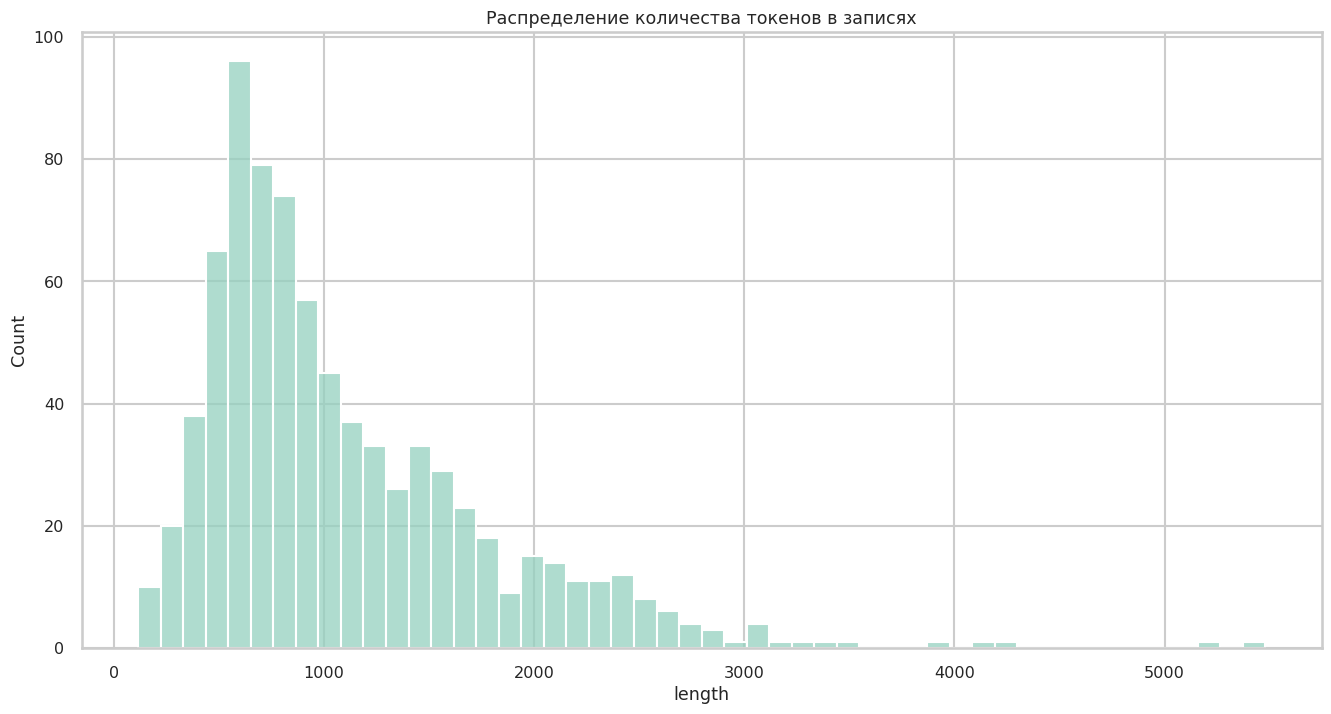

In [10]:
plot_len_distribution(train_dataset)

The number of records: 514
The mean length: 1087.7217898832685


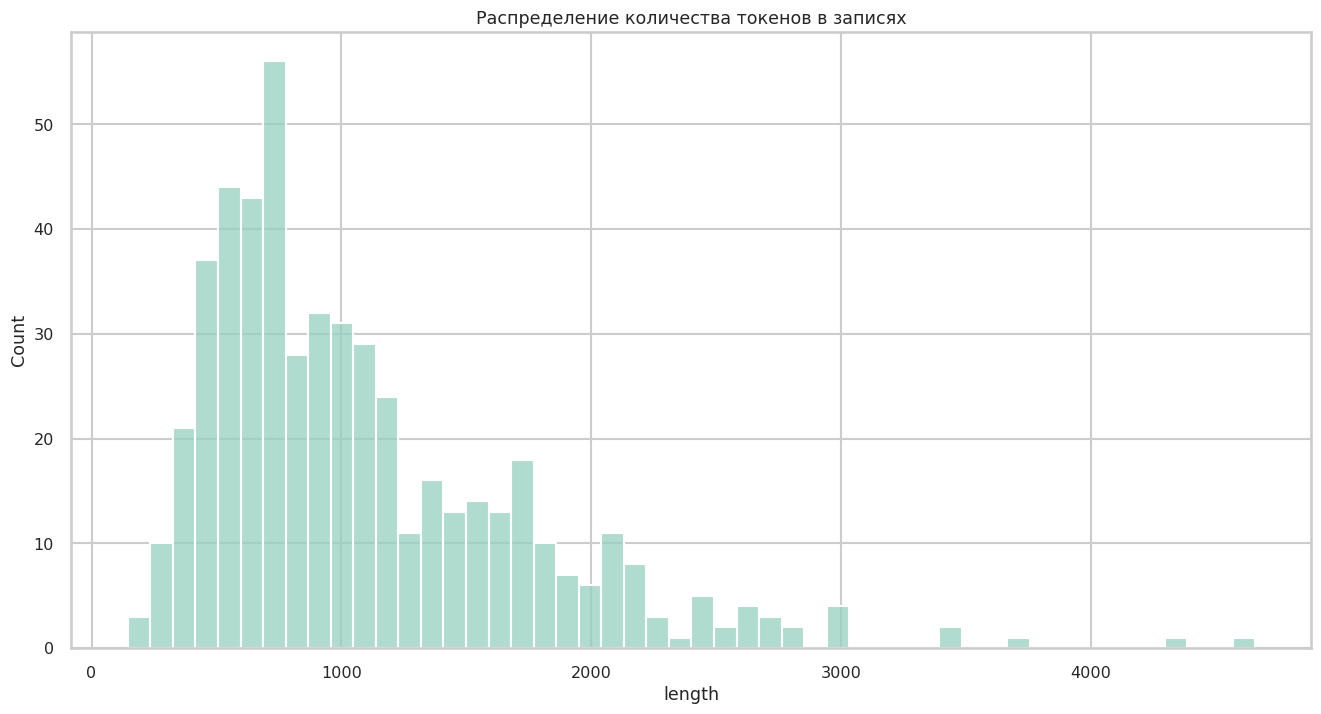

In [11]:
plot_len_distribution(val_dataset)

Распределение длин одинаково для тренировочной и валидационной выборок и схоже с колоколом распределения Пуассона.  
Примечательно, что средняя длина в обоих наборах данных почти совпадает.

#### i2b2 2006

In [12]:
data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
train_dataset = get_ner_dataset(data_type=data_config["train_data_type"],
                                path_to_folder=data_config["train_data_path"],
                                is_uncased=True,
                                pretrained_tokenizer="bert-large-uncased",
                                max_length=data_config["max_token_number"],
                                overlap=data_config["overlap"],
                                eq_max_padding=False, 
                                device="cpu")
val_dataset = get_ner_dataset(data_type=data_config["val_data_type"],
                              path_to_folder=data_config["validate_data_path"],
                              is_uncased=data_config["is_uncased"],
                              pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                              max_length=data_config["max_token_number"],
                              overlap=data_config["overlap"],
                              eq_max_padding=False, 
                              device="cpu")

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


The number of all tokens: 928383
O           819722
NAME         32057
DATE         21678
ID           21415
[PAD]        19394
LOCATION     11728
CONTACT       2338
AGE             51
Name: label, dtype: int64


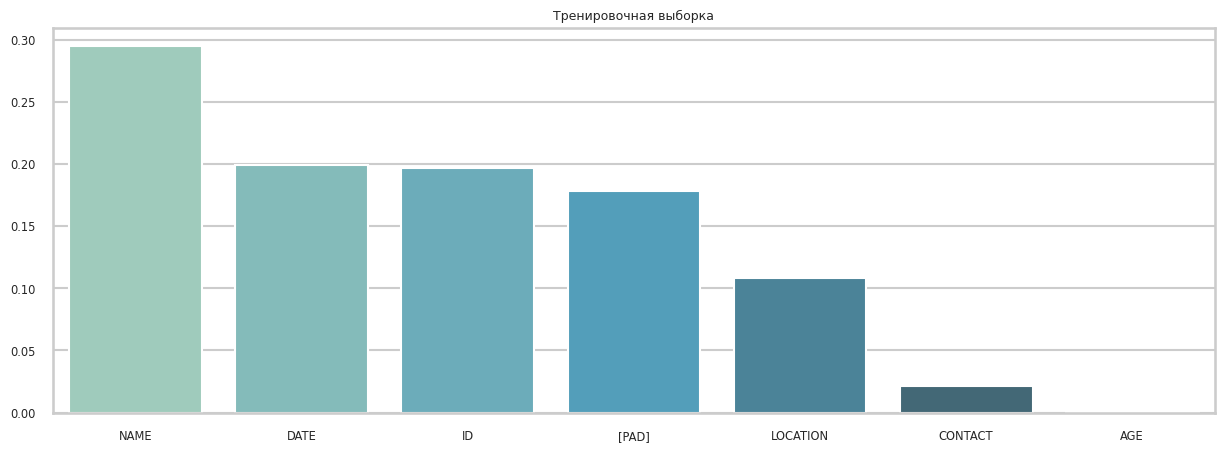

In [13]:
train_df = plot_class_distribution(train_dataset)

The number of all tokens: 385840
O           347028
NAME         10501
[PAD]         7968
DATE          7821
ID            6264
LOCATION      5534
CONTACT        714
AGE             10
Name: label, dtype: int64


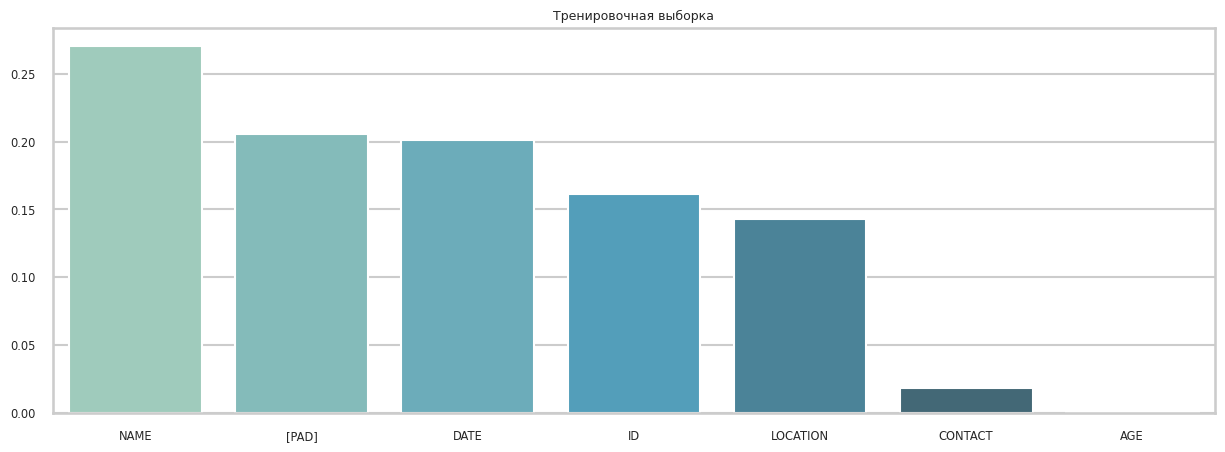

In [14]:
val_df = plot_class_distribution(val_dataset)

Заметим, что около $90\%$  токенов являются 'OTHER' и распозоваемые сущности занимают менее 10% всего текста, т.к одна пятая токенов являются техническими. Распознаваемые классы распределены более равномерно, чем в наборе данных за 2014 год, однако в нём отсутствует класс 'PROFESSION' и почти не представлен класс 'AGE' (51 токен). Среди присутсвующих самым популярным является класс 'NAME' --- $25\%$ токенов сущностей, оставшиеся классы занимают $<21\%$. А самым редким классом, который определён только у 714 токенов, является 'CONTACT', занимая лишь $~2\%$ токенов.  
Распределение классов в тренировочной и валидационной выборке совпадает. При этом обучающая выборка примерно в три раза больше тестовой.

In [15]:
train_dataset = get_ner_dataset(data_type=data_config["train_data_type"],
                                path_to_folder=data_config["train_data_path"],
                                is_uncased=True,
                                pretrained_tokenizer="bert-large-uncased",
                                max_length=None,
                                overlap=data_config["overlap"],
                                eq_max_padding=False, 
                                device="cpu")
val_dataset = get_ner_dataset(data_type=data_config["val_data_type"],
                              path_to_folder=data_config["validate_data_path"],
                              is_uncased=data_config["is_uncased"],
                              pretrained_tokenizer=data_config["pretrained_tokenizer_path"],
                              max_length=None,
                              overlap=data_config["overlap"],
                              eq_max_padding=False, 
                              device="cpu")

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


The number of records: 669
The mean length: 843.2406576980568


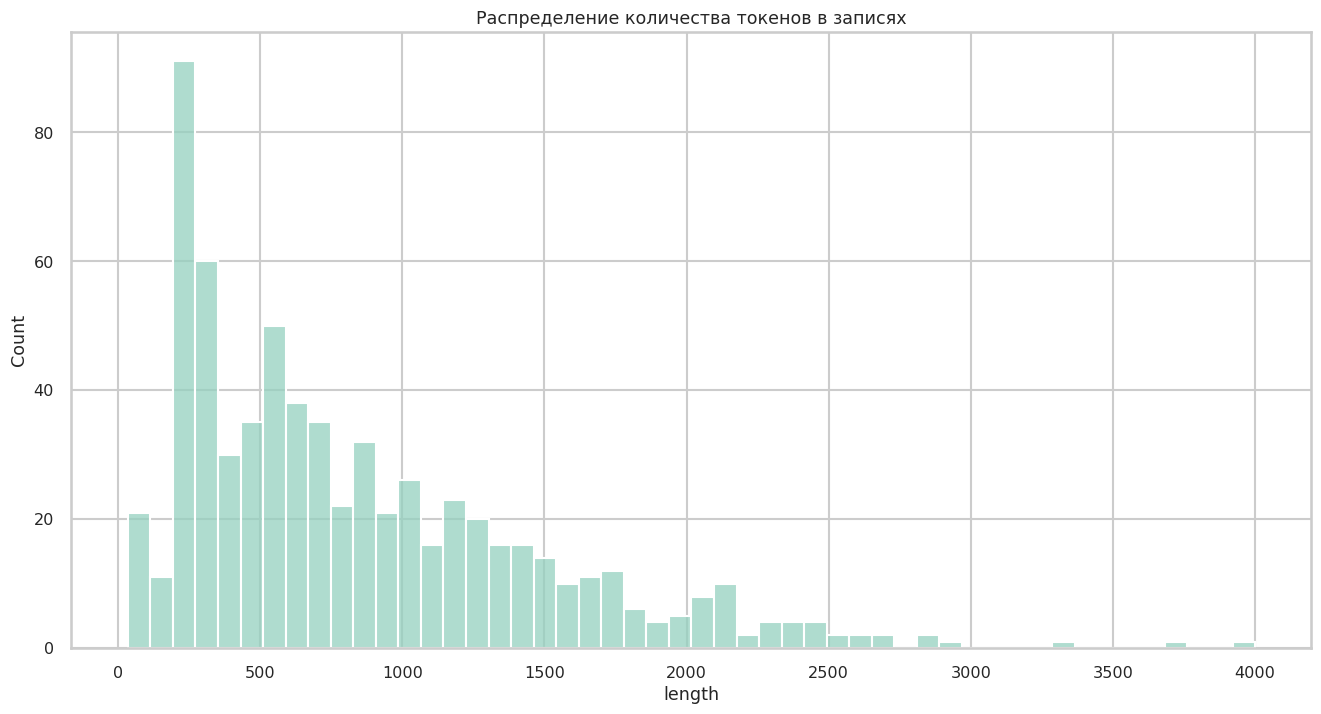

In [16]:
plot_len_distribution(train_dataset)

The number of records: 220
The mean length: 1060.090909090909


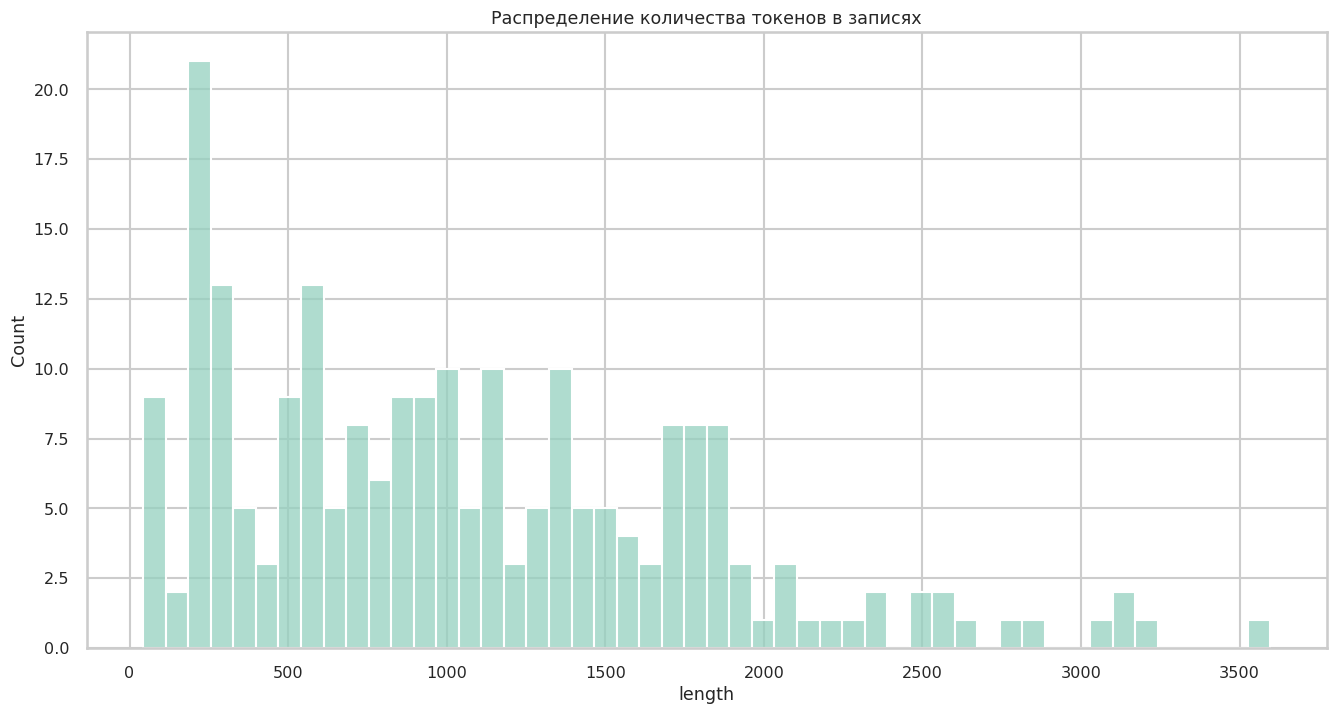

In [17]:
plot_len_distribution(val_dataset)

Распределение длин текстов в тренировочной и тестовой выборках несколько отличается: если в первой наблюдаются очертания колокола Пуассоновского распределения, то во второй распределение более пологое и ближе к равномерному.  
Стоит отметить, что средняя длина валидационных текстов на 200 токенов больше аналогичной у тренировочных.